<center><h1><font size=6> Exploratory Data Analysis (EDA) </h1></center>

### Load libraries and setup notebook configuration

In [1]:
# import packages
import pandas as pd 
import numpy as np
import os
from pathlib import Path
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math


# set pandas configurations
pd.set_option("display.precision", 2) # display to 1 decimpal place
pd.set_option("display.max.columns", None) # display all columns so we can view the whole dataset
pd.set_option('display.float_format', '{:.2f}'.format) # Disable scientific notation for pandas
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning) # Disable setting with copy warnings


# set directories
os.chdir('..') # change current working directory to the parent directory to help access files/directories at a higher level
DATAPATH = Path(r'data') # set data path


# import from source directory
from src import constants

### Load training data from local file

In [2]:
X_train_full = pd.read_csv(f"{DATAPATH}/processed/X_train_full.csv")
y_train_full = pd.read_csv(f"{DATAPATH}/processed/y_train_full.csv")
X_train_short = pd.read_csv(f"{DATAPATH}/processed/X_train_short.csv")
y_train_short = pd.read_csv(f"{DATAPATH}/processed/y_train_short.csv")
eda_full = X_train_full.merge(y_train_full, on='unique_match_id', how='left')
eda_short = X_train_short.merge(y_train_short, on='unique_match_id', how='left')

### Check for duplicate values

In [3]:
duplicates = eda_full.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Check for any missing values

In [4]:
# define function to summarise missing values
def missing_values_summary(df):
    missing_values = df.isnull().sum()  # Calculate total missing values per column
    total_values = df.shape[0]  # Total number of rows in the DataFrame
    missing_percentage = (missing_values / total_values) * 100  # Calculate percentage of missing values

    summary_df = pd.DataFrame({'Total Missing Values': missing_values, 'Missing Percentage': missing_percentage})
    return summary_df

# summarise missing values for data frame
summary = missing_values_summary(eda_full)
print(summary)

                                    Total Missing Values  Missing Percentage
unique_match_id                                        0                0.00
season                                                 0                0.00
date                                                   0                0.00
day_of_week                                            0                0.00
round                                                  0                0.00
day                                                    0                0.00
team                                                   0                0.00
promoted                                               0                0.00
opponent                                               0                0.00
promoted_opponent                                      0                0.00
home                                                   0                0.00
days_since_last_game                                 434                2.43

### Check the distribution of missing values

Wrap the below into a function and plot the distribution across things like:
- season
- gameweek round
- team
- promoted


In [5]:
# define a function to plot missing values of each variable across different categories
def plot_missing_values_by_category(data, category):
    
    # Calculate the number of missing values for each column grouped by the category
    missing_values_by_category = data.groupby(category).apply(lambda x: x.isnull().sum())
    
    # remove any columns that don't have any missing values
    column_sums = missing_values_by_category.sum() # Calculate the sum of each column
    nonzero_columns = column_sums[column_sums != 0] # Filter out columns where the sum is equal to 0
    missing_values_by_category = missing_values_by_category.loc[:, nonzero_columns.index] # Select only the columns with nonzero sum
    variables = missing_values_by_category.columns # collect list of variables to plot based on columns with missing values
    grid_size = math.ceil(math.sqrt(len(variables))) # get square root of the number of variables (rounded) as the grid size
    missing_values_by_category = missing_values_by_category.reset_index() # Reset index to make season a column
    
    # plot barchart of missing values across columns by category
    sns.set(rc={'figure.figsize':(25,25)})
    
    # for each variable/column, plot a bar chart of the missing values by the category
    for i, column in enumerate(variables, 1):
        plt.subplot(grid_size,grid_size,i)
        plt.xticks(rotation=65, horizontalalignment='right',)
        ax = sns.barplot(data=missing_values_by_category, x=category, y=column, color='blue')
        plt.title(column, loc='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

#### Across seasons

We can see that some metrics, such as the previous season stats, have missing values across different seasons consistently. This is due to promoted clubs not having this type of information. Other metrics, such as time, were only collected in more recent seasons and have lots of missing values.

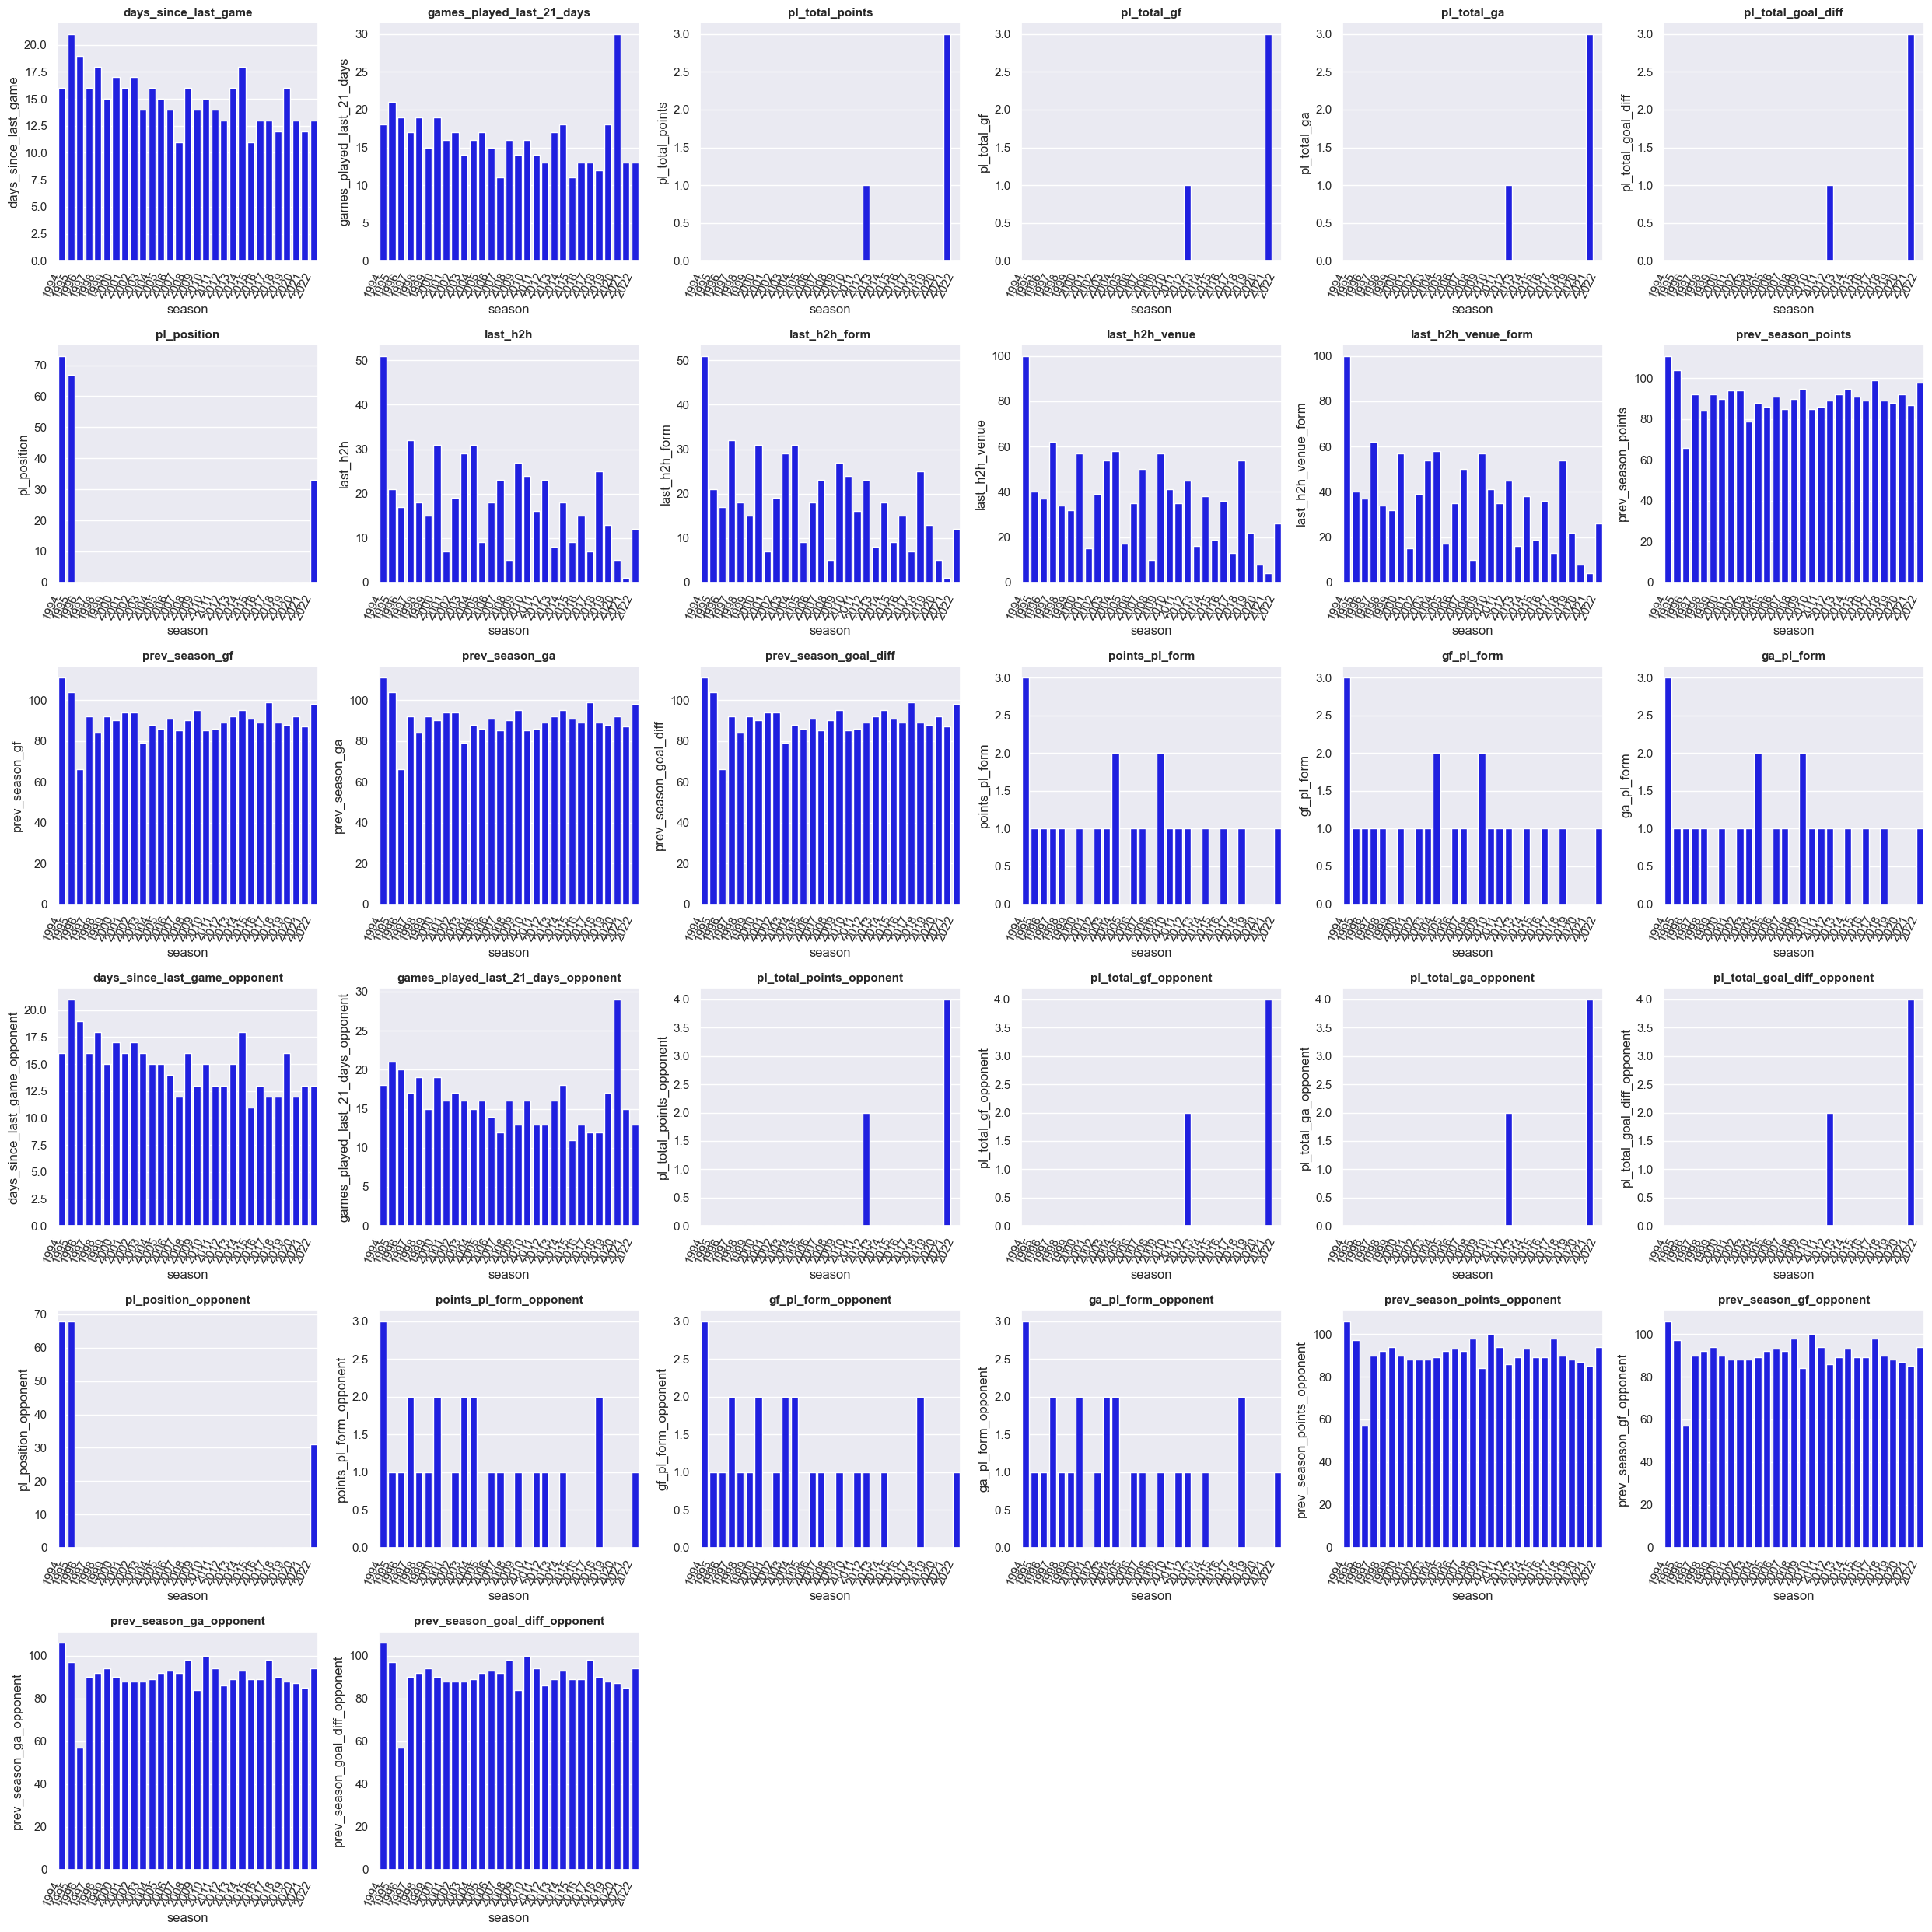

In [6]:
plot_missing_values_by_category(data=eda_full, category='season')

#### Across gameweeks

There are lots of metrics that have lots of missing values in early rounds of the premier league season because there is not enough data.

In [ ]:
plot_missing_values_by_category(data=eda_full, category='round')

#### Across promoted vs non-promoted teams

We can see that promoted teams account for a lot of the missing values for some variables, but in others they are split across both categories.

In [ ]:
plot_missing_values_by_category(data=eda_full, category='promoted')

### Describe the data

In [ ]:
eda_full.describe().T

In [ ]:
numeric_columns

### Plot distributions of the data

In [ ]:
# select columns to plot - ignore 'opponent' columns as they'll be the same 
distribution_colums = ['days_since_last_game', 'games_played_last_21_days',
       'pl_total_points', 'pl_total_gf', 'pl_total_ga', 'pl_total_goal_diff',
       'pl_position', 'last_h2h', 'last_h2h_form', 'last_h2h_venue',
       'last_h2h_venue_form', 'prev_season_points', 'prev_season_gf',
       'prev_season_ga', 'prev_season_goal_diff', 'points_pl_form',
       'gf_pl_form', 'ga_pl_form']
num_plots = len(distribution_colums)
grid_size = math.ceil(math.sqrt(num_plots))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(25, 25))

for i, column in enumerate(distribution_colums):
    row = i // grid_size
    col = i % grid_size

    x = eda_full[column].dropna().values
    axes[row, col].hist(x=x.flatten(), bins='auto', edgecolor='k')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_title(column)

# Remove empty subplots
if num_plots < grid_size**2:
    for i in range(num_plots, grid_size**2):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Correlations

In [ ]:
from matplotlib.colors import TwoSlopeNorm

# define a set of useful numeric columns to plot correlations
useful_columns =  eda_full.select_dtypes(include=['number']).columns
useful_columns = [col for col in useful_columns if not col.endswith('_opponent')] # remove opponent columns as they are symmetrical

# define function to get redundant pairs (i.e., a column with itself)
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0,df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

# define function to calculate correlations and collect top n in absolute terms
def get_correlations(df,n=30):
    au_corr = df.corr(method = 'spearman').unstack() #spearman used because not all data is normalized
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
    top_n = au_corr[0:n]    
    bottom_n =  au_corr[-n:]
    top_corr = pd.concat([top_n, bottom_n])
    return top_corr

# create correlation plot
corrplot = get_correlations(eda_full[useful_columns])

# plot
fig, ax = plt.subplots(figsize=(15,10))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax =1)
colors = [plt.cm.RdYlGn(norm(c)) for c in corrplot.values]
corrplot.plot.barh(color=colors)

### Correlations with the target variable

In [ ]:
# correlations vs target
target = 'points'
df = eda_full.drop(columns=['unique_match_id', target])
# define a set of useful numeric columns to plot correlations
useful_columns =  df.select_dtypes(include=['number']).columns


x = eda_full[useful_columns].corrwith(eda_full[target], method = 'spearman').sort_values(ascending=False)
colors = [plt.cm.RdYlGn(norm(c)) for c in x.values]
x.plot.barh(color=colors)

x_all = x